In [5]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
import numpy as np
np.random.seed(0)

In [7]:
DATASET = "pastis"
RAW_DATA_SUFFIX = "full-pastis-RGB"
FINAL_DATA_NAME = 'pastis-full' 
CONSTANT_SAMPLE_SIZE = int(1e5)

num_images=1000
jitter=False 
normalize=False 
n_bootstrap=1000

data_dir = os.path.join(ROOT_DIR, 'raw-data', DATASET, RAW_DATA_SUFFIX)

Gabor

In [3]:
import git
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import convolve
from scipy.stats import bootstrap
from scipy import stats
from scipy.stats import skew
import cv2
import warnings
from tqdm.notebook import tqdm
from PIL import Image

warnings.filterwarnings("ignore")
np.set_printoptions(legacy='1.25')
np.random.seed(0)

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)

# import torch
# import torchvision
# import torchvision.transforms as transforms
# import torch.nn.functional as F

# alexnet = torchvision.models.alexnet(pretrained=True)
# alexnet.eval()  
# first_conv = alexnet.features[0]
# filters = first_conv.weight.data.clone().cpu().numpy().transpose(0, 2, 3, 1)  # shape: [out_channels, in_channels, height, width]

filters = pd.read_pickle(os.path.join(ROOT_DIR, 'learned-filters', 'filters.pickle'))

def load_images_from_directory(directory, n=None, jitter=False, normalize=False):

    all_images = os.listdir(directory)
    num_images = len(all_images)

    if not n:
        n = num_images

    images = []
    subset = np.random.permutation(num_images)[:n]
    
    for i in tqdm(subset, desc="Loading images"):
        filename = all_images[i]
        if filename.endswith(".npz"):
            img = np.load(os.path.join(directory, filename))["image"].astype(np.float64)
        elif filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(directory, filename)).astype(np.float64)
        elif filename.endswith(".tif"):
            img = np.array(cv2.imread(os.path.join(directory, filename), cv2.IMREAD_UNCHANGED)).astype(np.float64)
            if img.ndim == 2:  # grayscale image
                img = np.stack([img] * 3, axis=-1)

        if jitter:
            img += np.random.uniform(-0.5, 0.5, size=img.shape)
        if normalize:
            img = (img - np.mean(img))/np.std(img)
        images.append(img)

    return np.array(images)

def bootstrap_metric(x, metric=None, n_bootstrap=1000, bootstrap_size = 10000, ci=0.99, replace=True):
    metric_values = []
    for _ in tqdm(range(n_bootstrap)):
        resampled = np.random.choice(x, size=bootstrap_size, replace=replace)
        metric_values.append(metric(resampled))
        
    metric_point_estimate = metric(x)
    ci_lower = np.percentile(metric_values, (1 - ci) / 2 * 100)
    ci_upper = np.percentile(metric_values, (1 + ci) / 2 * 100)
    
    return metric_point_estimate, ci_lower, ci_upper, metric_values


In [ ]:
# --- Load previously saved Gabor filter responses ---
import os
import numpy as np
import pandas as pd

gabor_pickle_path = os.path.join(ROOT_DIR, 'transformed-data', f"{FINAL_DATA_NAME}-gabor.pickle")
gabor_size_path   = os.path.join(ROOT_DIR, 'transformed-data', f"{FINAL_DATA_NAME}-gabor-size.pickle")

if not os.path.exists(gabor_pickle_path):
    raise FileNotFoundError(f"Missing: {gabor_pickle_path}")
if not os.path.exists(gabor_size_path):
    raise FileNotFoundError(f"Missing: {gabor_size_path}")

# Dict: {filter_idx -> 1D np.ndarray of sampled responses}
filter_data_map = pd.read_pickle(gabor_pickle_path)
# Dict: {filter_idx -> total_samples_without_subsampling}
total_samples_by_filter = pd.read_pickle(gabor_size_path)

# Ensure well-typed (in case keys got cast)
filter_data_map = {int(k): np.asarray(v) for k, v in filter_data_map.items()}
total_samples_by_filter = {int(k): int(v) for k, v in total_samples_by_filter.items()}

# Quick sanity summary
n_filters = len(filter_data_map)
first_key = sorted(filter_data_map.keys())[0]
example = filter_data_map[first_key]
print(f"Loaded Gabor responses for {n_filters} filters.")
print(f"Example: filter {first_key} has {example.size} sampled coeffs; "
      f"original pixels per filter (pre-subsample) ≈ {total_samples_by_filter[first_key]:,}.")


Loaded Gabor responses for 90 filters.
Example: filter 0 has 100000 sampled coeffs; original pixels per filter (pre-subsample) ≈ 49,152,000.


In [ ]:
# --- Reload Gabor parameter table and align to filter_data_map keys ---

import os
import pandas as pd
import numpy as np

# Keys of saved responses (usually 0..N-1)
keys = sorted(int(k) for k in filter_data_map.keys())
n_filters = len(keys)

# Path used earlier when generating kernels
param_csv_path = os.path.join(ROOT_DIR, "gabor", "gabor_test.csv")
if not os.path.exists(param_csv_path):
    raise FileNotFoundError(f"Could not find Gabor params CSV at: {param_csv_path}")

param_df = pd.read_csv(param_csv_path)

# Basic schema checks
required_cols = {"frequency", "wave_number", "aspect_ratio"}
missing = required_cols - set(param_df.columns)
if missing:
    raise ValueError(f"Param CSV is missing required columns: {missing}")

# Make sure we have at least as many rows as filters we saved
if max(keys) >= len(param_df):
    raise IndexError(
        f"Param table has only {len(param_df)} rows but filter_data_map contains index {max(keys)}."
        " Ensure you're using the same param CSV that created the saved Gabor bank."
    )

# Align parameter rows to the exact filter indices we have
params = param_df.iloc[keys].copy()

# If you didn’t vary theta when generating (you set theta=0.0), fill it; otherwise use CSV column
if "theta" not in params.columns:
    params["theta"] = 0.0

# Now build filters_df with these params as columns
filters_df = pd.DataFrame(
    index=keys,
    columns=["skew", "skew_ci_low", "skew_ci_high", "frequency", "wave_number", "aspect_ratio", "theta"]
)

filters_df.loc[keys, "frequency"]    = params["frequency"].to_numpy()
filters_df.loc[keys, "wave_number"]  = params["wave_number"].astype(int).to_numpy()
filters_df.loc[keys, "aspect_ratio"] = params["aspect_ratio"].to_numpy()
filters_df.loc[keys, "theta"]        = params["theta"].to_numpy()

print(f"Loaded params for {n_filters} Gabor filters from {param_csv_path}.")


Loaded params for 90 Gabor filters from d:\new research\hierarchical-bayesian-model-validation\gabor\gabor_full.csv.


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Saved: d:\new research\hierarchical-bayesian-model-validation\dataset-preparation\pastis\pastis-full_gabor_skewness_df.csv
Updated: d:\new research\hierarchical-bayesian-model-validation\gabor-filters\nonskewed_filter_idxs_df.csv

Non-skewed rate by wave_number:
              nonskewed  count  %_nonskewed
wave_number                               
2                   10     30     0.333333
3                   15     30     0.500000
4                   16     30     0.533333

Non-skewed rate by frequency bin:
                    nonskewed  count  %_nonskewed
frequency                                       
(0.000501, 0.101]         17     66     0.257576
(0.101, 0.201]             6      6     1.000000
(0.201, 0.3]               6      6     1.000000
(0.3, 0.4]                 6      6     1.000000
(0.4, 0.5]                 6      6     1.000000


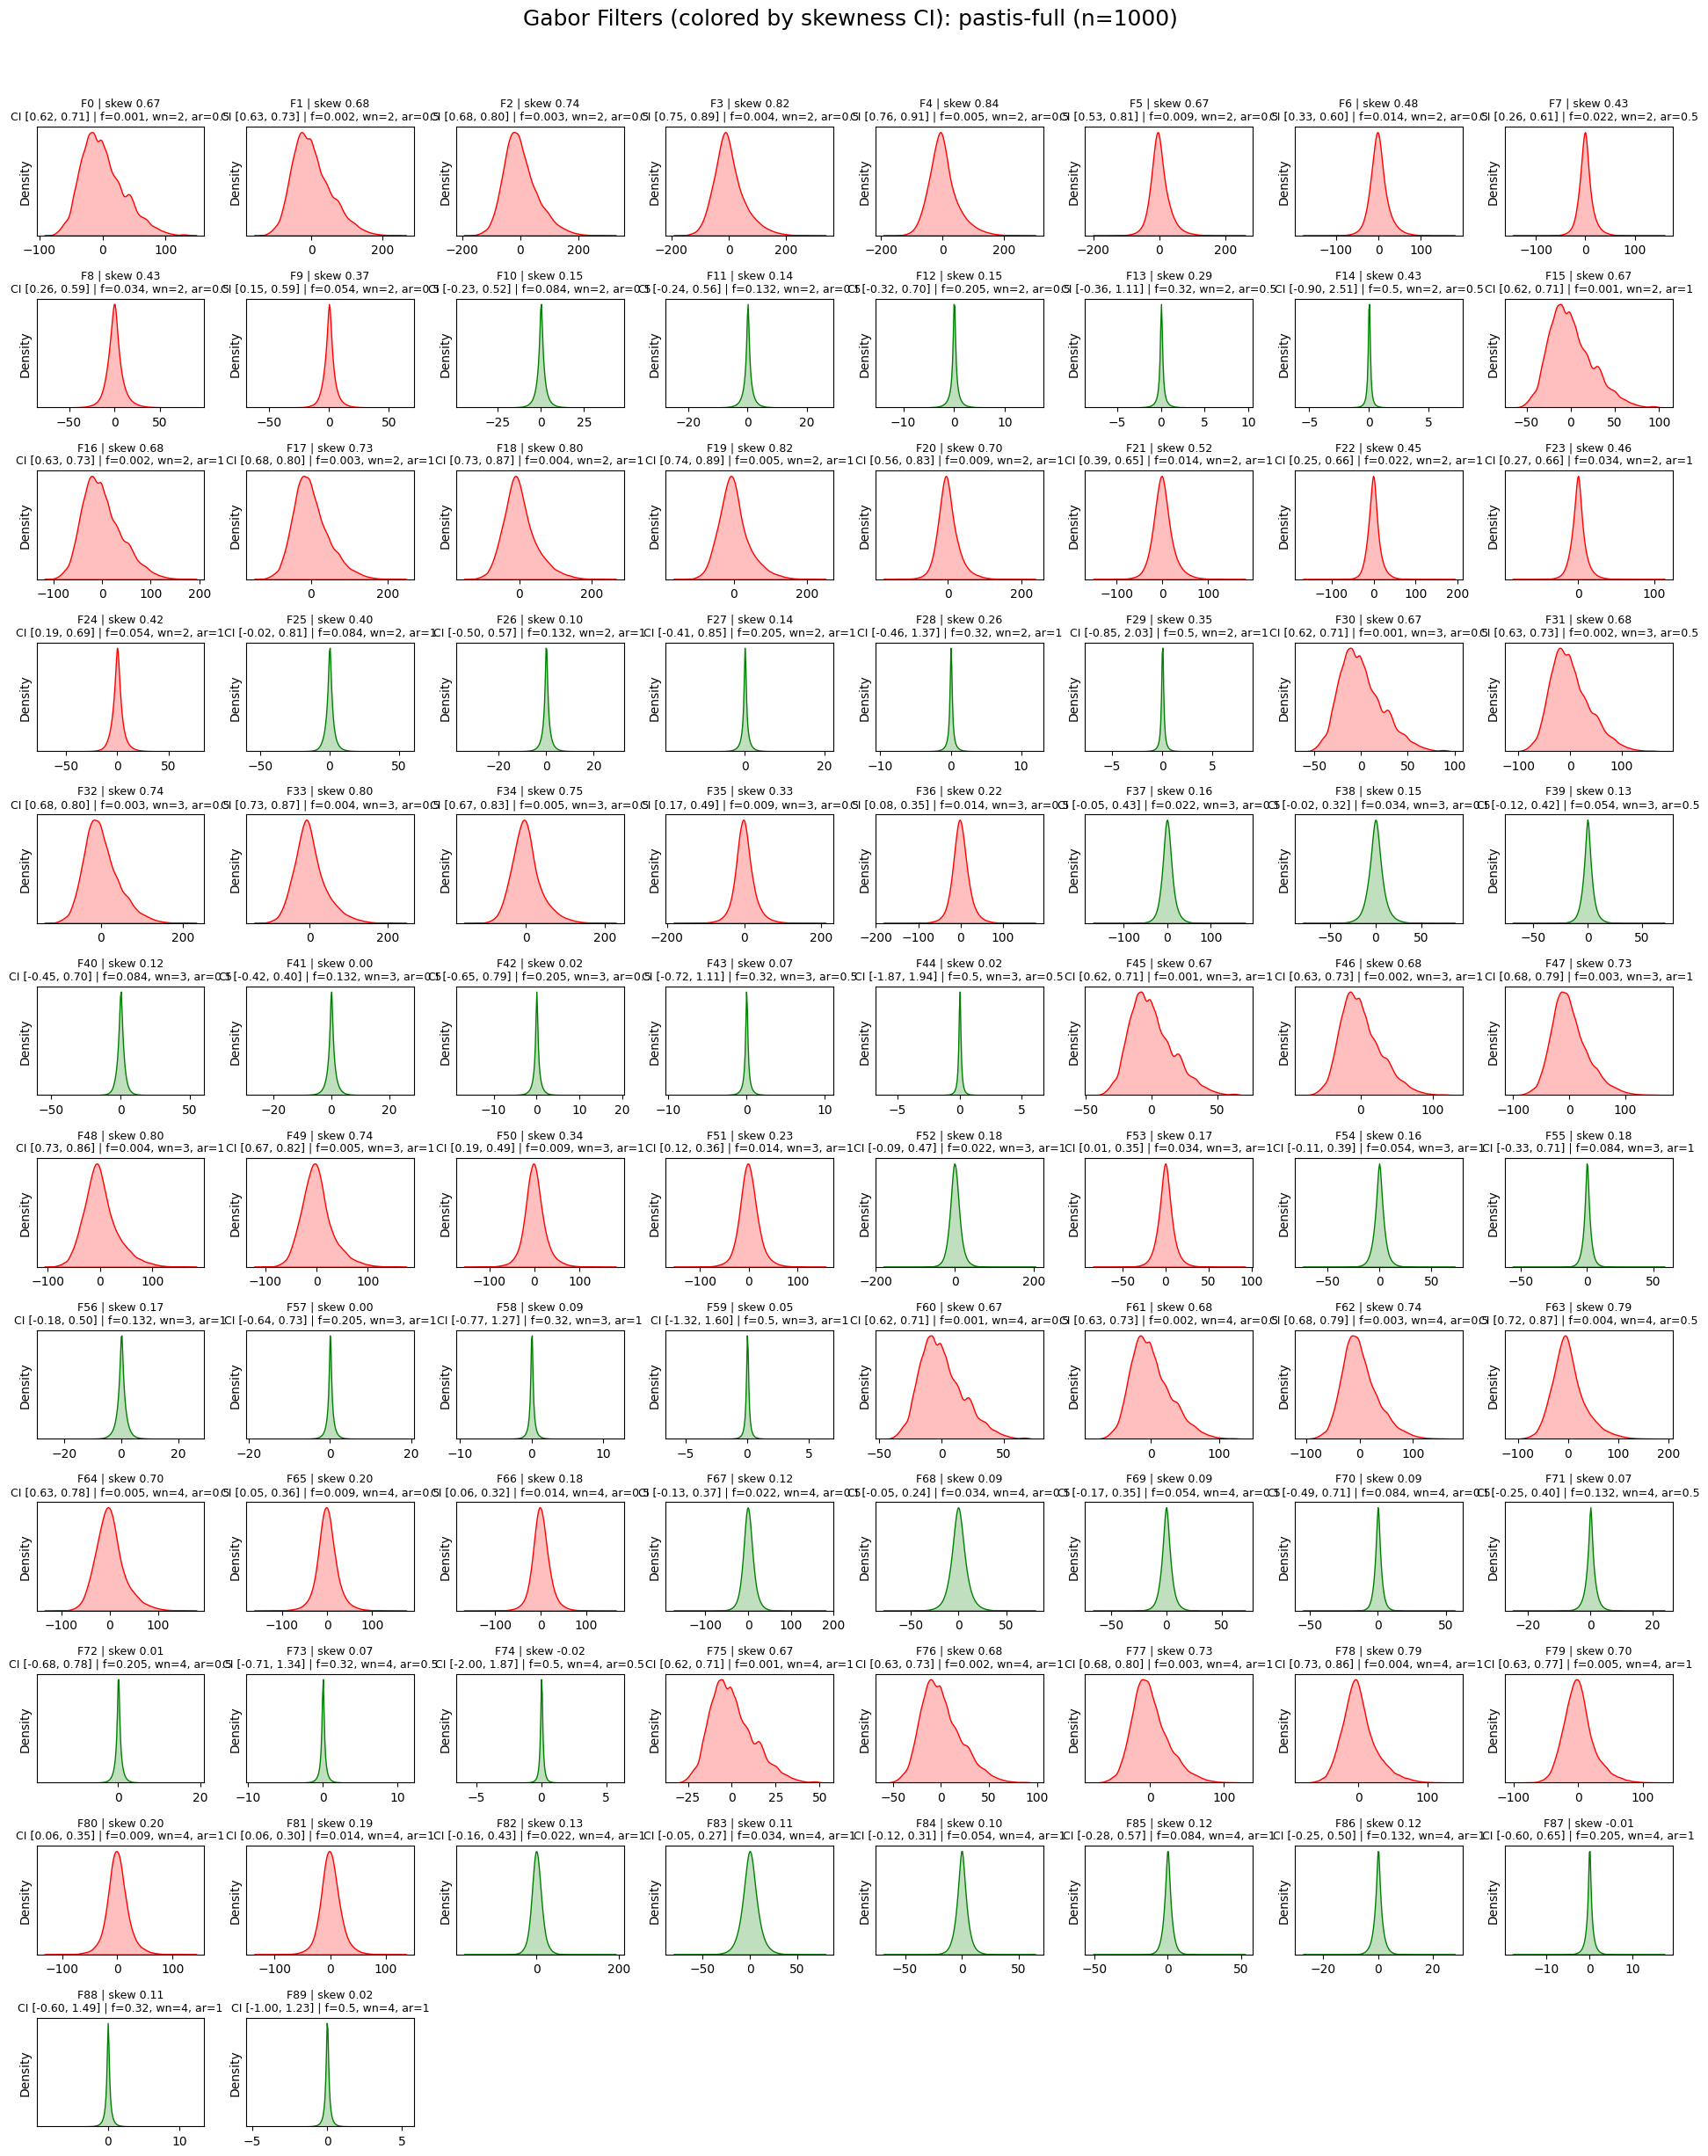

Saved: d:\new research\hierarchical-bayesian-model-validation\dataset-preparation\pastis\pastis-full_gabor_skewness.jpg


In [ ]:
# --- Gabor skewness bootstrap & plots (mirrors your learned-filter flow) ---

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Ensure output dirs exist
os.makedirs(os.path.join(ROOT_DIR, 'dataset-preparation', DATASET), exist_ok=True)
os.makedirs(os.path.join(ROOT_DIR, 'gabor-filters'), exist_ok=True)

# If you already saved the transformed responses, you can load them like this:
gabor_pickle_path = os.path.join(ROOT_DIR, 'transformed-data', f"{FINAL_DATA_NAME}-gabor.pickle")
if 'filter_data_map' not in globals():
    filter_data_map = pd.read_pickle(gabor_pickle_path)

# Build a results DF and include the Gabor params alongside the stats
n_filters = len(filter_data_map)
filters_df = pd.DataFrame(index=range(n_filters),
                          columns=['skew', 'skew_ci_low', 'skew_ci_high',
                                   'frequency', 'wave_number', 'aspect_ratio', 'theta'])

# Pull params from your CSV (assumes same ordering as your filters list)
filters_df['frequency']   = param_df['frequency'].values[:n_filters]
filters_df['wave_number'] = param_df['wave_number'].astype(int).values[:n_filters]
filters_df['aspect_ratio'] = param_df['aspect_ratio'].values[:n_filters]
filters_df['theta'] = 0.0  # you set theta=0 for all when generating kernels

# ---- Bootstrap settings (match/adjust as you like) ----
# sanity-check first with smaller numbers if needed.
bootstrap_ci = 0.95
bootstrap_size = 10_000
n_bootstrap = n_bootstrap  

# Compute skew + CI per filter
for filter_idx, data in filter_data_map.items():
    sk_point = skew(data)
    sk_point_boot, ci_lower, ci_upper, _ = bootstrap_metric(
        x=data, metric=skew, ci=bootstrap_ci,
        n_bootstrap=n_bootstrap, bootstrap_size=bootstrap_size
    )
    # Store the *point estimate* and CI; you can store sk_point_boot if you prefer the bootstrapped mean
    filters_df.loc[filter_idx, 'skew'] = float(sk_point)
    filters_df.loc[filter_idx, 'skew_ci_low'] = float(ci_lower)
    filters_df.loc[filter_idx, 'skew_ci_high'] = float(ci_upper)

# Flag non-skewed filters (CI includes 0)
filters_df['nonskewed'] = (filters_df['skew_ci_low'] <= 0.0) & (filters_df['skew_ci_high'] >= 0.0)

# Save detailed results
out_csv = os.path.join(ROOT_DIR, 'dataset-preparation', DATASET, f"{FINAL_DATA_NAME}_gabor_skewness_df.csv")
filters_df.to_csv(out_csv, index_label='filter_idx')
print(f"Saved: {out_csv}")

# Also persist the 'nonskewed' list into a small registry (similar to your learned-filters flow)
registry_path = os.path.join(ROOT_DIR, 'gabor-filters', 'nonskewed_filter_idxs_df.csv')
dataset_key = f"{FINAL_DATA_NAME}-gabor"

nonskewed_filter_idxs = list(filters_df.index[filters_df['nonskewed'] == True])
try:
    ns_df = pd.read_csv(registry_path).set_index(['dataset', 'num_images', 'num_bootstrap'])
except FileNotFoundError:
    ns_df = pd.DataFrame(columns=['dataset', 'num_images', 'num_bootstrap', 'nonskewed_filter_idxs']) \
            .set_index(['dataset', 'num_images', 'num_bootstrap'])

ns_df.loc[(dataset_key, num_images if num_images is not None else -1, n_bootstrap), :] = {
    'dataset': dataset_key,
    'num_images': num_images if num_images is not None else -1,
    'num_bootstrap': n_bootstrap,
    'nonskewed_filter_idxs': nonskewed_filter_idxs
}
ns_df.to_csv(registry_path)
print(f"Updated: {registry_path}")

# Quick summary cuts (optional): by wave_number and frequency bins
by_wave = (filters_df.groupby('wave_number')['nonskewed']
           .agg(['sum', 'count']).rename(columns={'sum':'nonskewed'}))
by_wave['%_nonskewed'] = by_wave['nonskewed'] / by_wave['count']
print("\nNon-skewed rate by wave_number:\n", by_wave)

freq_bins = pd.cut(filters_df['frequency'], bins=5)
by_freq = (filters_df.groupby(freq_bins)['nonskewed']
           .agg(['sum', 'count']).rename(columns={'sum':'nonskewed'}))
by_freq['%_nonskewed'] = by_freq['nonskewed'] / by_freq['count']
print("\nNon-skewed rate by frequency bin:\n", by_freq)

# --------- Visualization (like your learned-filters grids) ---------
ncols = 8
nrows = int(np.ceil(n_filters / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(2.4*ncols, 2.0*nrows))
axes = axes.flatten()
fig.suptitle(f"Gabor Filters (colored by skewness CI): {FINAL_DATA_NAME} (n={num_images})", y=1.02, fontsize=18)

for i, (filter_idx, data) in enumerate(filter_data_map.items()):
    ax = axes[i]
    color = 'green' if filters_df.loc[filter_idx, 'nonskewed'] else 'red'
    sns.kdeplot(data, ax=ax, fill=True, color=color)
    sk = filters_df.loc[filter_idx, 'skew']
    ci_l = filters_df.loc[filter_idx, 'skew_ci_low']
    ci_h = filters_df.loc[filter_idx, 'skew_ci_high']
    f = filters_df.loc[filter_idx, 'frequency']
    wn = int(filters_df.loc[filter_idx, 'wave_number'])
    ar = filters_df.loc[filter_idx, 'aspect_ratio']
    ax.set_title(f"F{filter_idx} | skew {sk:.2f}\nCI [{ci_l:.2f}, {ci_h:.2f}] | f={f:.3g}, wn={wn}, ar={ar:.2g}",
                 fontsize=9)
    ax.set_yticks([])

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
fig_path = os.path.join(ROOT_DIR, 'dataset-preparation', DATASET, f"{FINAL_DATA_NAME}_gabor_skewness.jpg")
plt.savefig(fig_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"Saved: {fig_path}")
